Adapted from https://github.com/ritchie46/vanilla-machine-learning and https://github.com/ex4sperans/variational-inference-with-normalizing-flows/ 

In [26]:
import torch
import torch.distributions as dist
from torch import nn
import torch.nn.functional as F
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns

In [27]:
%config InlineBackend.figure_format='retina'
sns.set()

In [28]:
def safe_log(z):
    return torch.log(z + 1e-7)

In [29]:
class NormalizingFlow(nn.Module):

    """from https://github.com/ex4sperans/variational-inference-with-normalizing-flows/blob/master/flow.py"""
    def __init__(self, dim, flow_length):
        super().__init__()

        self.transforms = nn.Sequential(*(
            PlanarFlow(dim) for _ in range(flow_length)
        ))

        self.log_jacobians = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms
        ))
        
        self.mu = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        self.log_var = nn.Parameter(torch.zeros(dim).uniform_(-0.01, 0.01))
        
        self.flow_length = flow_length
        self.dim = dim

    def forward(self, n_sample):
        
        std = torch.exp(0.5 * self.log_var)
        eps = torch.randn((n_sample, self.dim))  
        z0 = self.mu + eps * std

        z = z0
        
        ldj = torch.zeros((self.flow_length, n_sample, 1))

        for i in range(self.flow_length):
        
            transform, log_jacobian = self.transforms[i], self.log_jacobians[i]
            ldj[i] = log_jacobian(z)
            z = transform(z)

        zk = z

        return z0, zk, ldj, self.mu, self.log_var


class PlanarFlow(nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.weight = nn.Parameter(torch.zeros((1, dim)).uniform_(-0.01, 0.01))
        self.bias = nn.Parameter(torch.zeros(1).uniform_(-0.01, 0.01))
        self.scale = nn.Parameter(torch.zeros((1,dim)).uniform_(-0.01, 0.01))
        self.tanh = nn.Tanh()

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.tanh(activation)


class PlanarFlowLogDetJacobian(nn.Module):
    """A helper class to compute the determinant of the gradient of
    the planar flow transformation."""

    def __init__(self, affine):
        super().__init__()

        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return safe_log(det_grad.abs())

In [30]:
def det_loss(x, mu, log_var, z_0, z_k, ldj, beta=1.):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    # batch_size = z_0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z_0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    
    # P(x|z)
    nll = -dist.Normal(z_k[:, 0], torch.exp(0.5 * z_k[:, 1])).log_prob(x).sum() * beta
    
    return log_qzk + nll  #) #/ batch_size

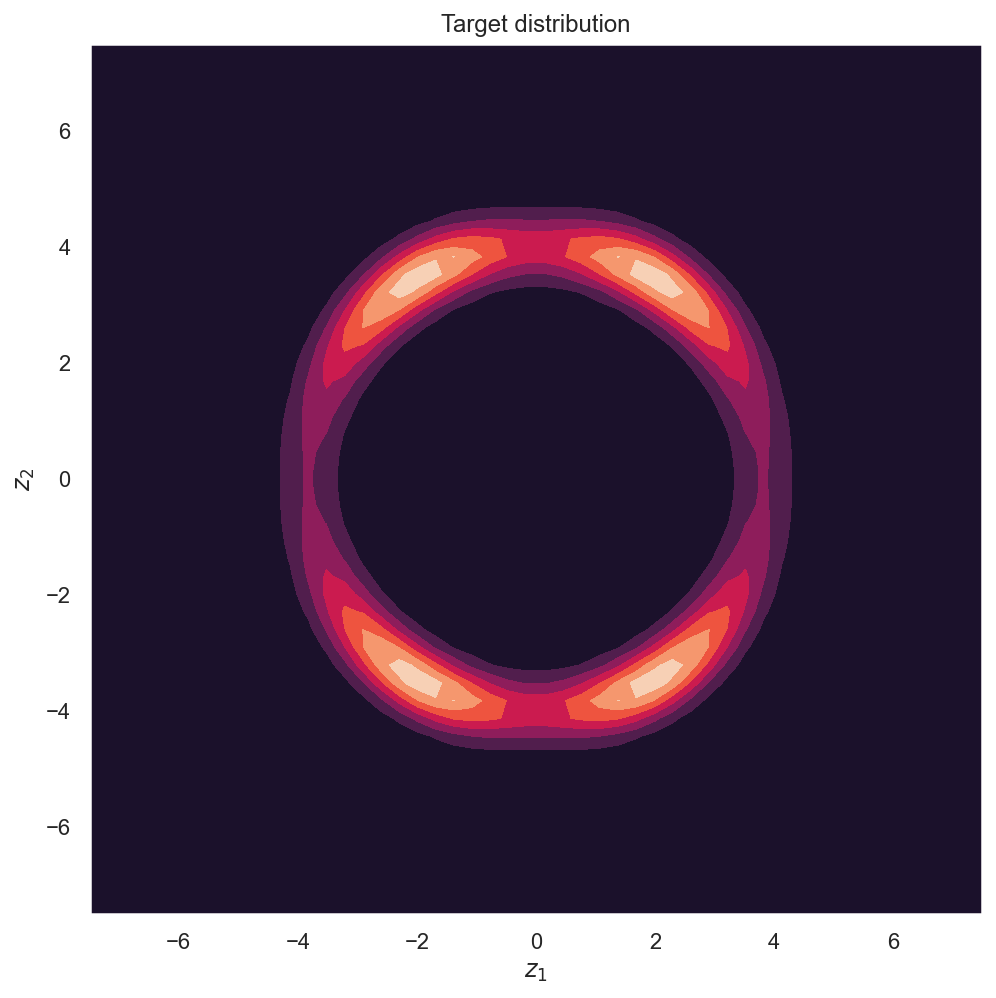

In [31]:
def target_density(z):
    z1, z2 = z[..., 0], z[..., 1]
    norm = (z1**2 + z2**2)**0.5
    exp1 = torch.exp(-0.2 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.2 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return torch.exp(-u)

x1 = np.linspace(-7.5, 7.5)
x2 = np.linspace(-7.5, 7.5)
x1_s, x2_s = np.meshgrid(x1, x2)
x_field = np.concatenate([x1_s[..., None], x2_s[..., None]], axis=-1)
x_field = torch.tensor(x_field, dtype=torch.float)

plt.figure(figsize=(8, 8))
plt.title("Target distribution")
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.contourf(x1_s, x2_s, target_density(x_field))
plt.show()

In [37]:
def det_loss(mu, log_var, z0, zk, ldj, beta):
    # Note that I assume uniform prior here.
    # So P(z) is constant and not modelled in this loss function
    batch_size = z0.size(0)

    # Qz0
    log_qz0 = dist.Normal(mu, torch.exp(0.5 * log_var)).log_prob(z0)
    # Qzk = Qz0 + sum(log det jac)
    log_qzk = log_qz0.sum() - ldj.sum()
    # P(x|z)
    nll = -torch.log(target_density(zk) + 1e-7).sum() * beta
    return (log_qzk + nll) / batch_size

In [43]:
def train_flow(flow_length, n_sample=1000, epochs=1000):
    
    flow = NormalizingFlow(dim=2, flow_length=flow_length)
    
    optim = torch.optim.Adam(flow.parameters(), lr=1e-2)

    hist_loss = np.zeros(epochs)
    with tqdm(total=epochs) as pbar:
        
        for i in range(epochs):
            
            z0, zk, ldj, mu, log_var = flow(n_sample=n_sample)
            
            loss = det_loss(mu=mu,
                            log_var=log_var,
                            z0=z0,
                            zk=zk,
                            ldj=ldj,
                            beta=1)
            loss.backward()
            hist_loss[i] = loss.item()

            optim.step()
            optim.zero_grad()
            if i % 50 == 0:
                pbar.set_postfix({'loss': loss.item()})

            pbar.update()
    
    return flow, hist_loss

In [44]:
def show_samples(s0, sk, mu, title):
    
    alpha = 0.2
    
    mask_1 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] > mu[1])
    mask_2 = (z0.data[:, 0] > mu[0]) & (z0.data[:, 1] < mu[1])
    mask_3 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] > mu[1])
    mask_4 = (z0.data[:, 0] < mu[0]) & (z0.data[:, 1] < mu[1])
    
    for s, title in zip([s0, sk], ['Base distribution $z_0$', title]):
        plt.figure(figsize=(8, 8))
        plt.title(title)
        plt.scatter(s[:, 0][mask_1], s[:, 1][mask_1], color='C0', alpha=alpha)
        plt.scatter(s[:, 0][mask_2], s[:, 1][mask_2], color='C1', alpha=alpha)
        plt.scatter(s[:, 0][mask_3], s[:, 1][mask_3], color='C3', alpha=alpha)
        plt.scatter(s[:, 0][mask_4], s[:, 1][mask_4], color='C4', alpha=alpha)

        plt.xlim(-7.5, 7.5)
        plt.ylim(-7.5, 7.5)
        plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]

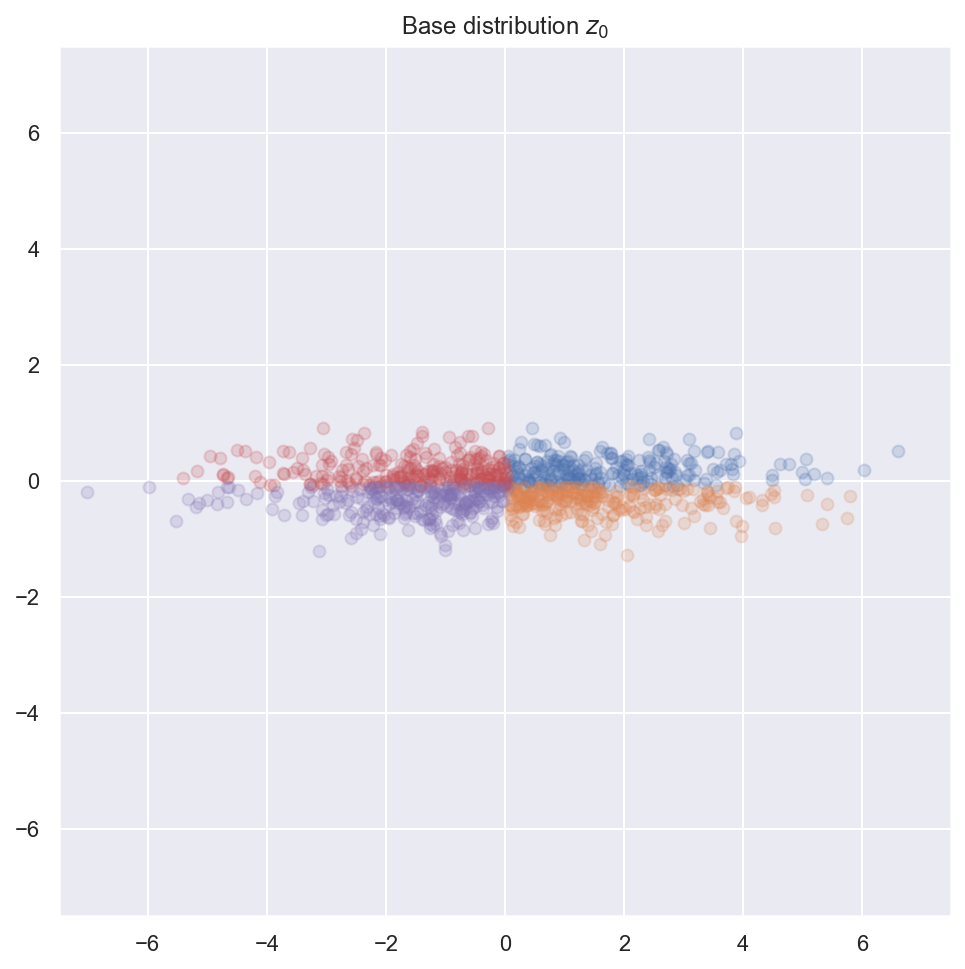

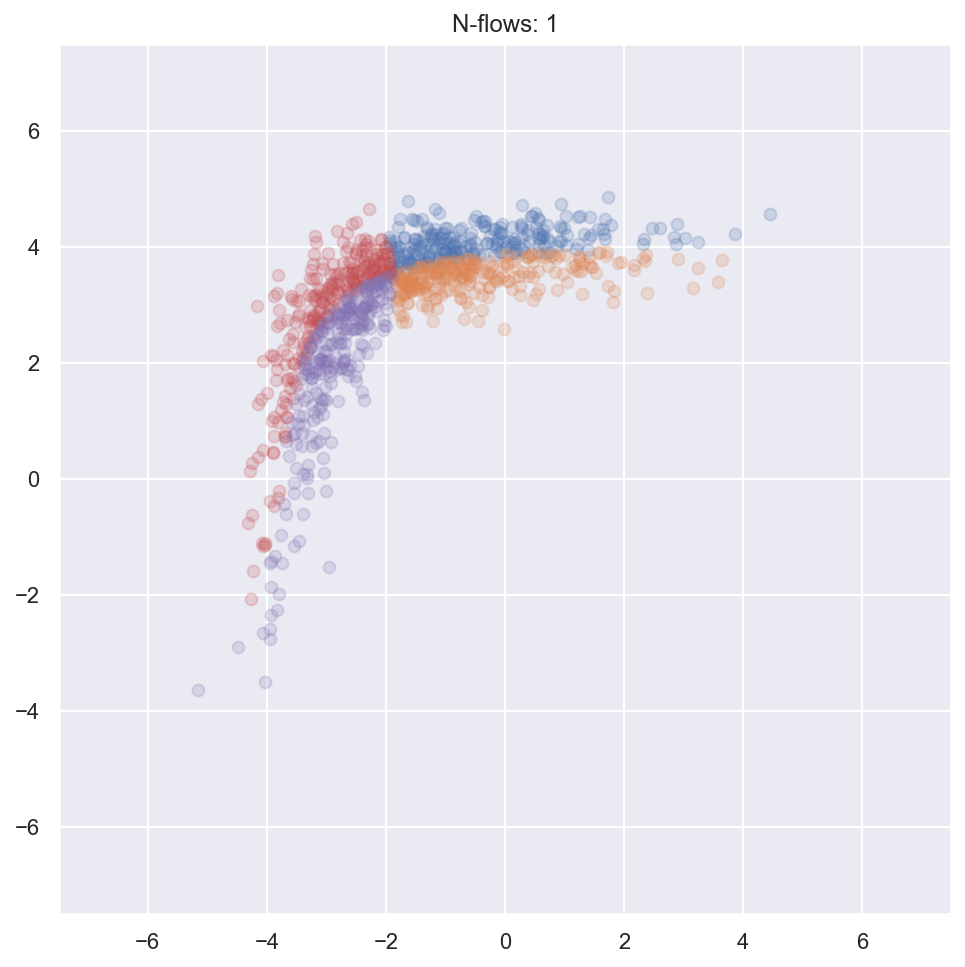

  0%|          | 0/5000 [00:00<?, ?it/s]

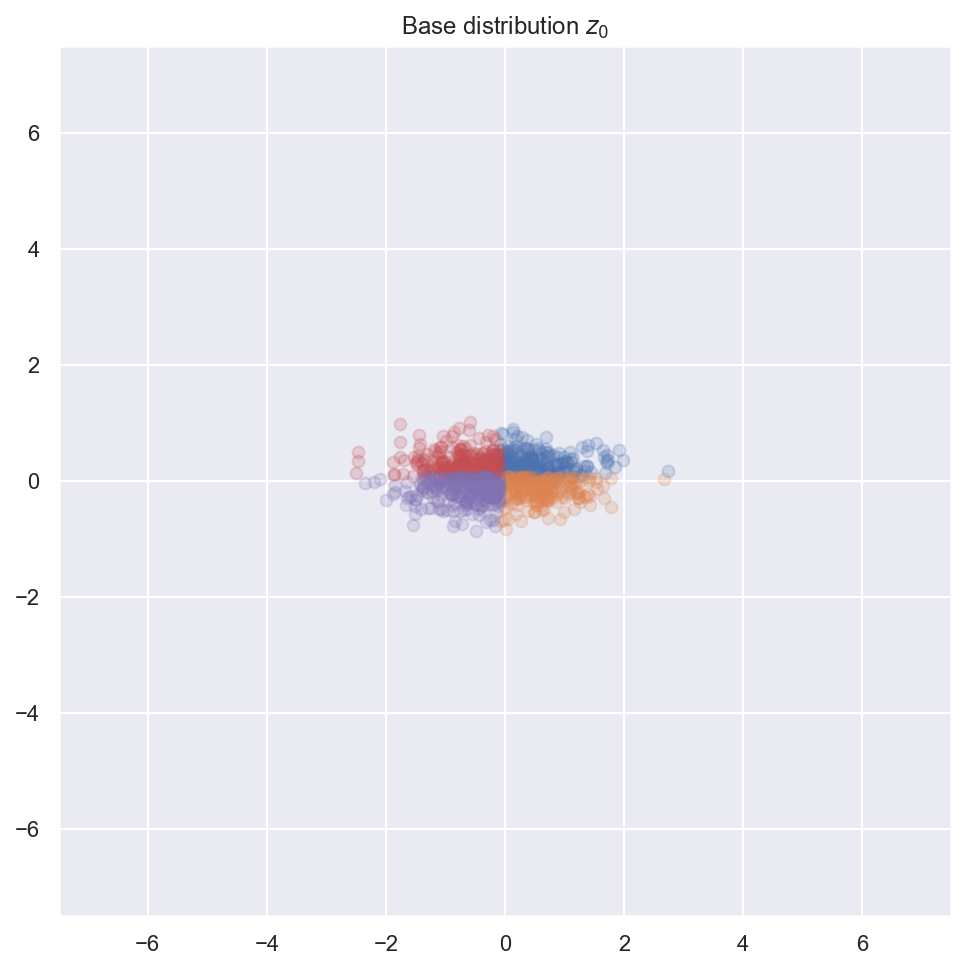

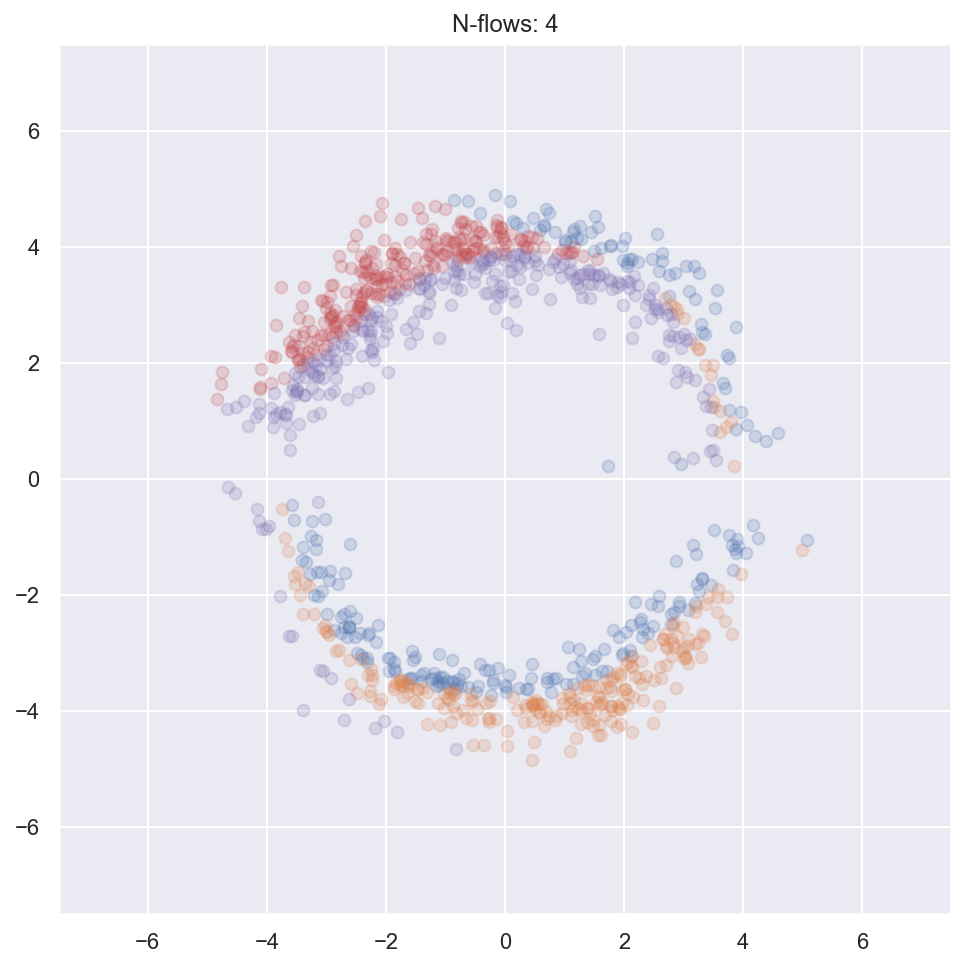

  0%|          | 0/5000 [00:00<?, ?it/s]

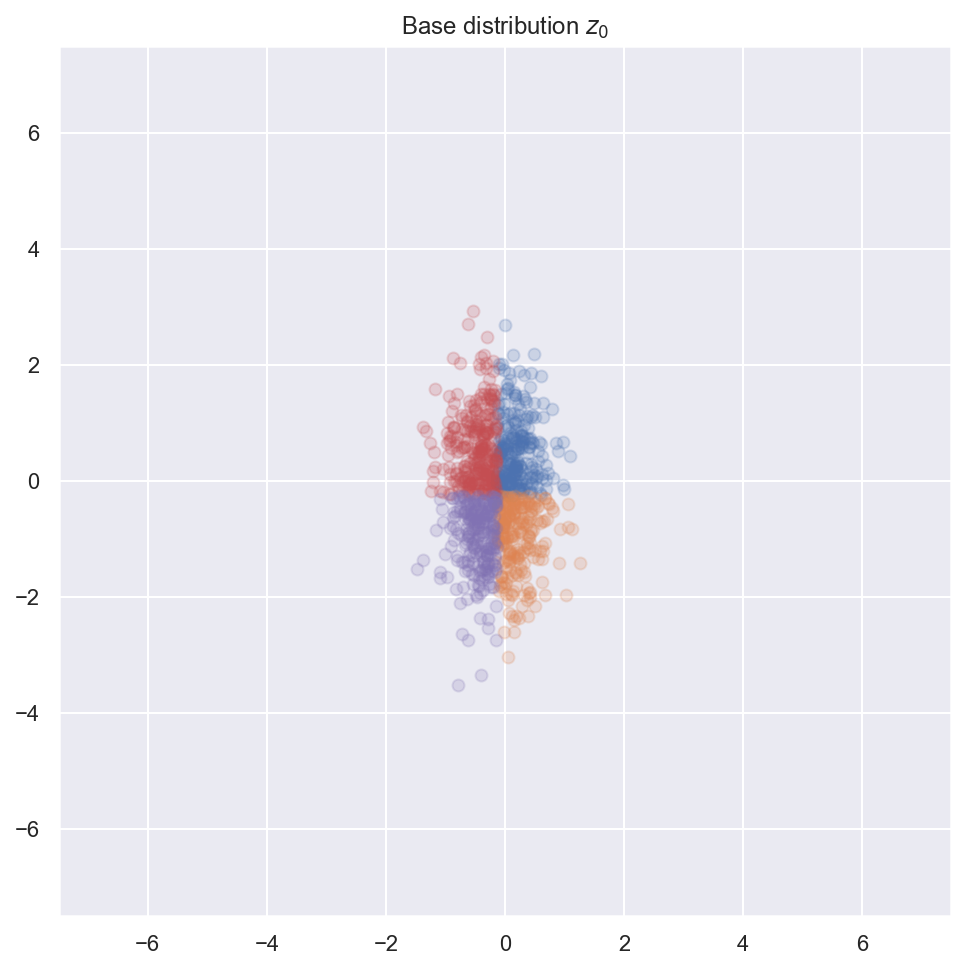

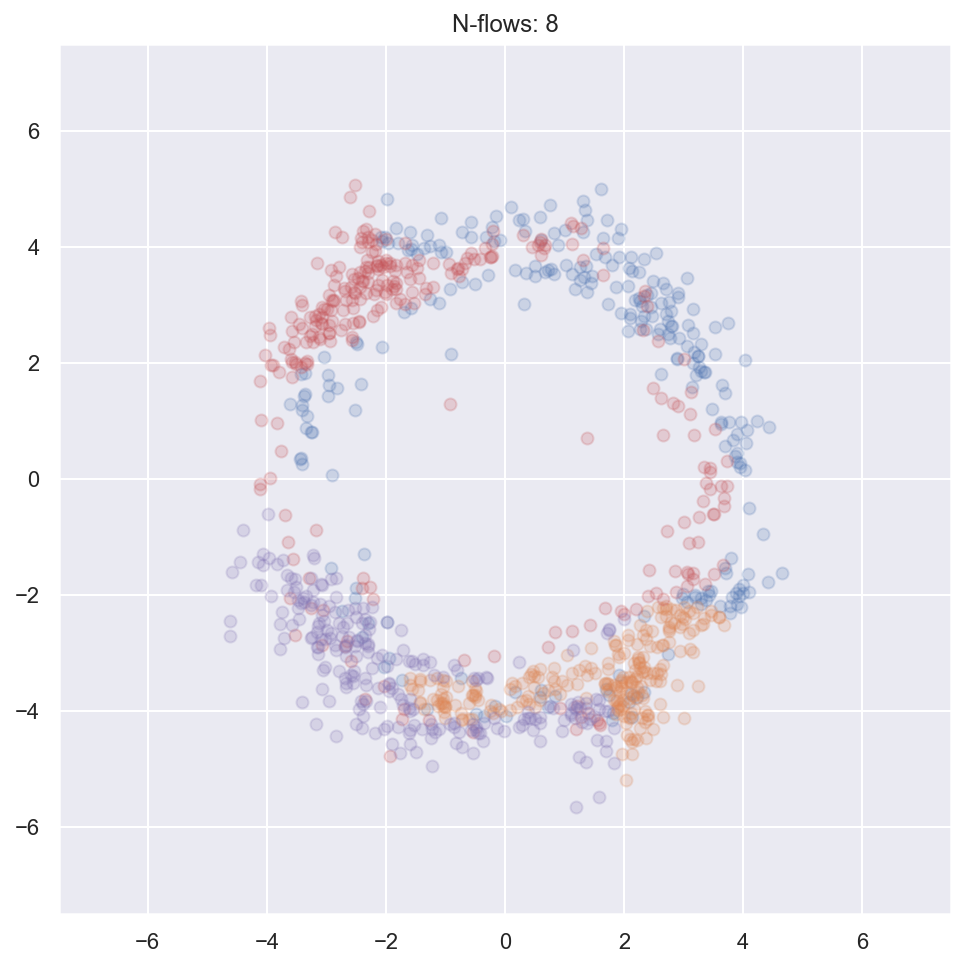

  0%|          | 0/5000 [00:00<?, ?it/s]

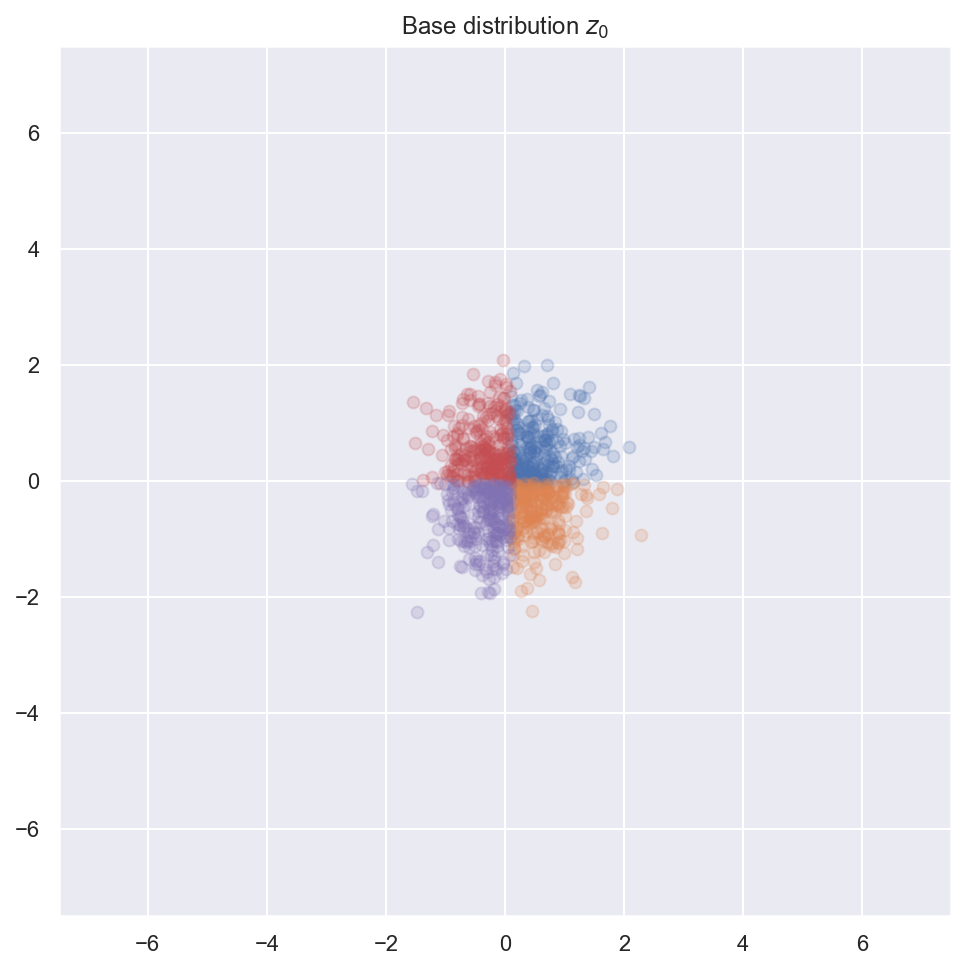

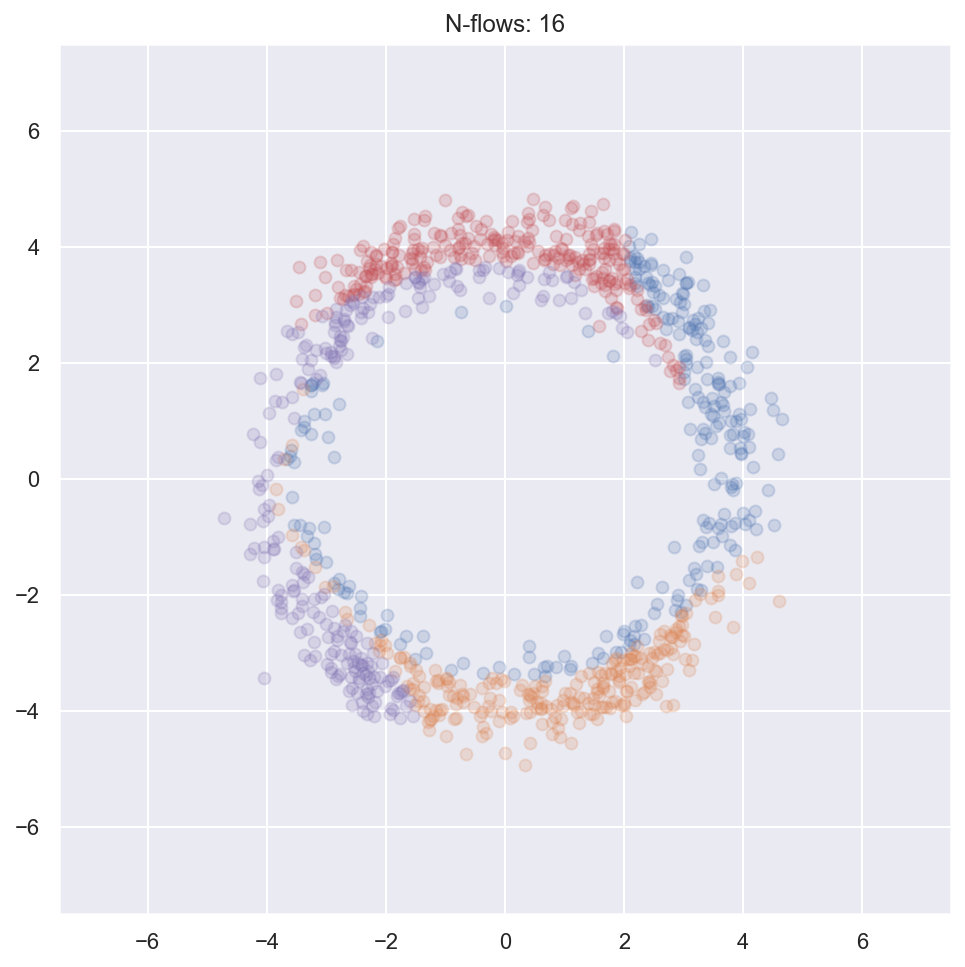

In [46]:
for flow_length in [1, 4, 8, 16]:
    flow, hist_loss = train_flow(flow_length=flow_length, n_sample=1000, epochs=5000)
    z0, zk, ldj, mu, log_var = flow(n_sample=1000)
    show_samples(z0.data, zk.data, mu, f"N-flows: {flow_length}")